In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../TileEM/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


# Snowballing method of tile picking heuristic 

In [41]:
cd ..

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


  0%|          | 0/20 [00:00<?, ?it/s]

Working on obj: 5
Picked top-k tiles
Creating random subsets from topk tiles


KeyboardInterrupt: 

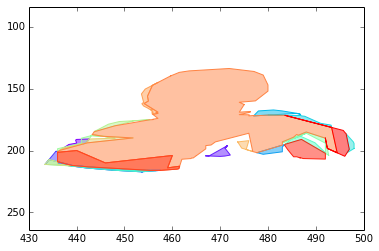

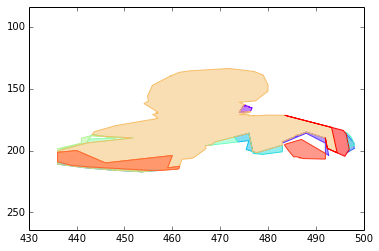

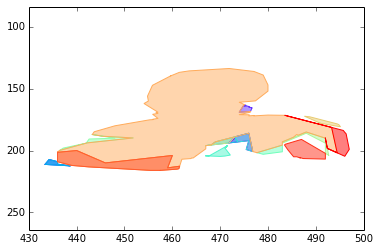

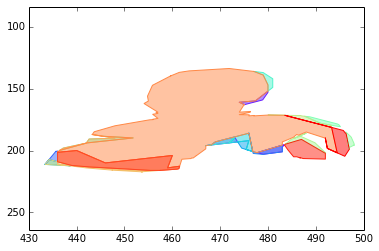

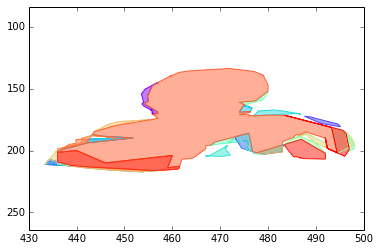

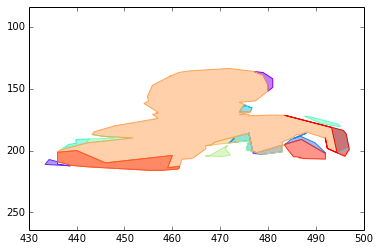

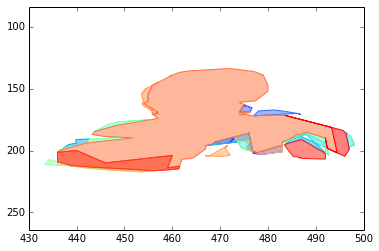

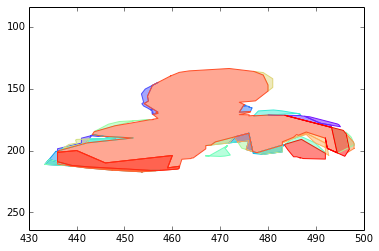

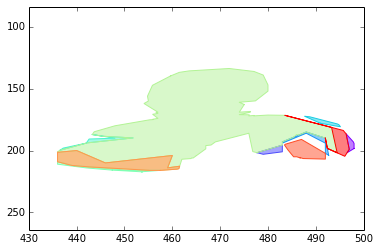

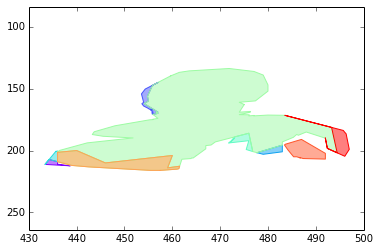

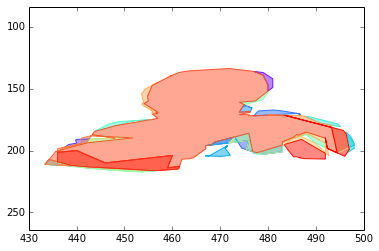

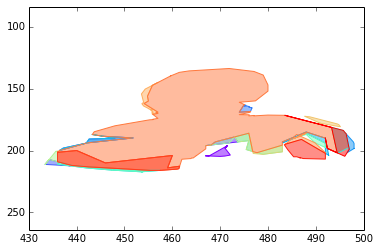

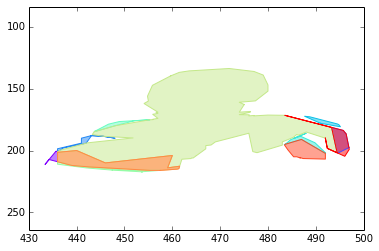

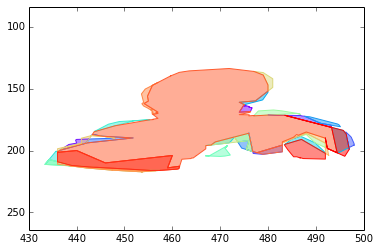

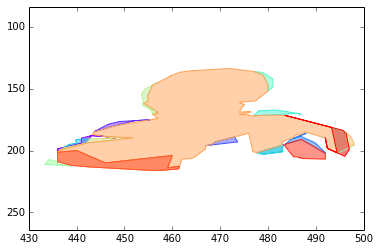

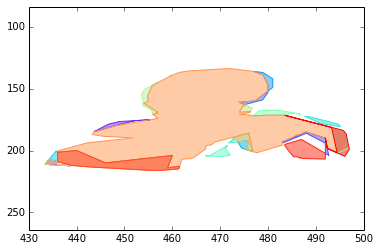

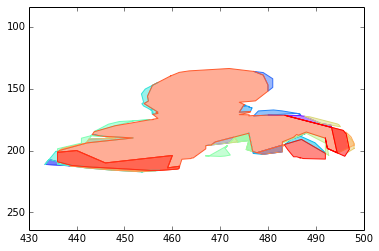

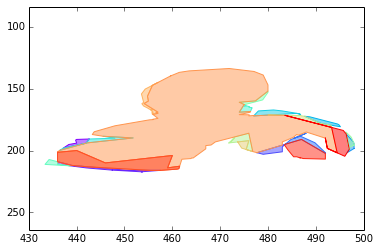

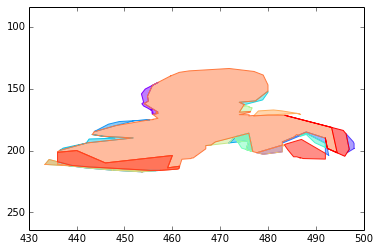

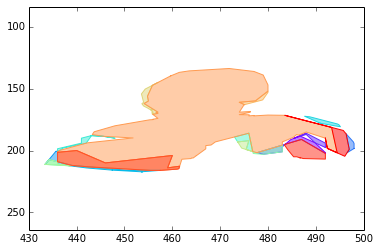

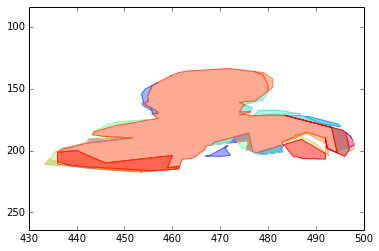

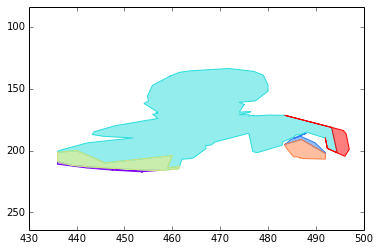

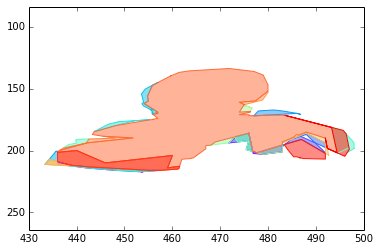

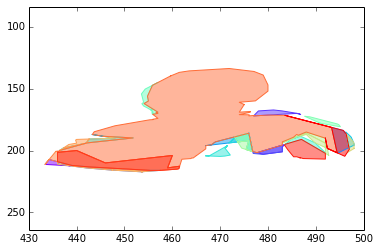

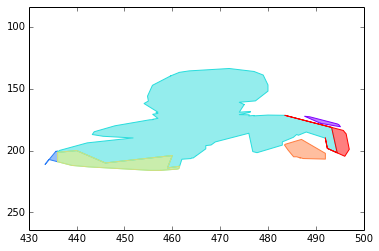

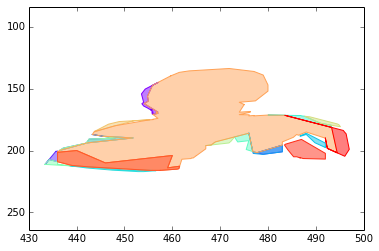

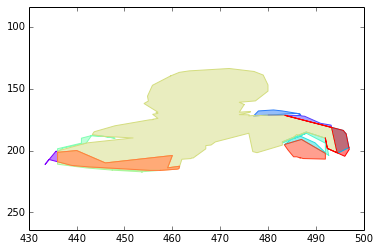

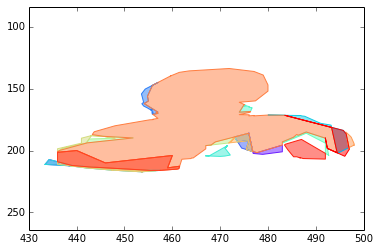

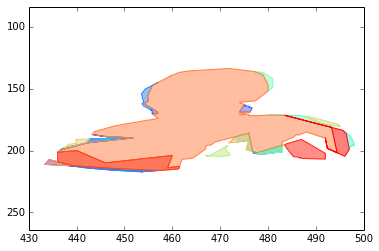

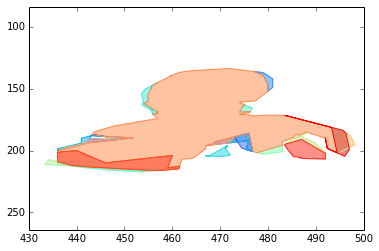

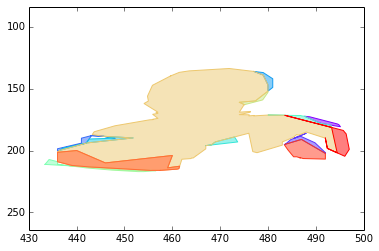

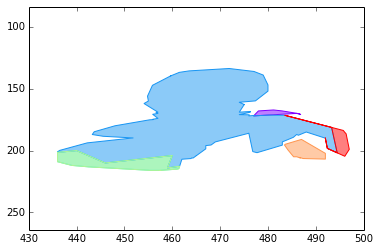

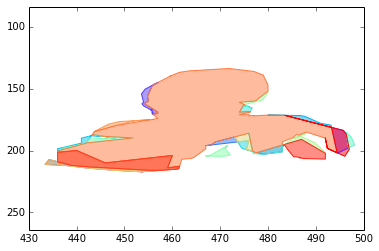

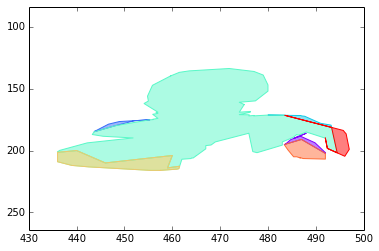

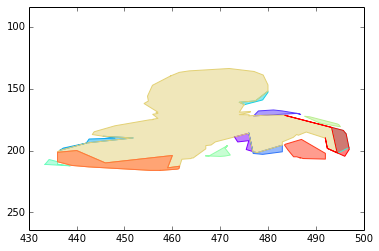

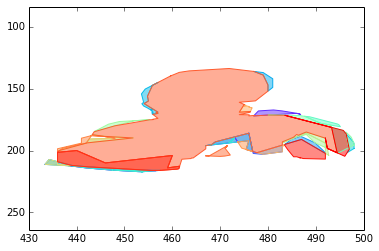

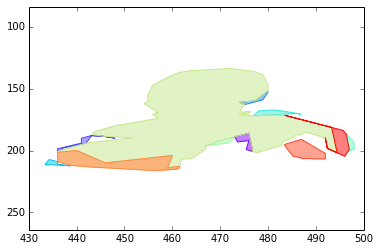

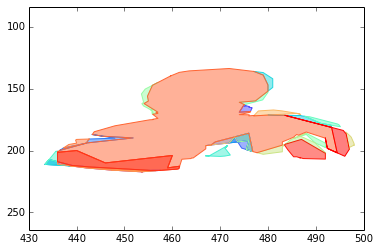

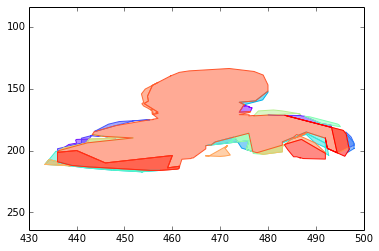

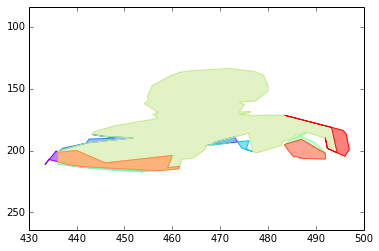

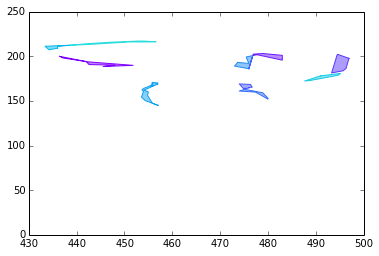

In [42]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from TileEM_plot_toolbox import *
from TileEM_Models import *
gamma_properties=False
DATA_DIR="final_all_tiles"
os.chdir(DATA_DIR)
try: 
    topTilePickHeuristic=sys.argv[1]
except(IndexError):
    topTilePickHeuristic="area"
fixedtopk=5
topk = 40
training_tbl = []
my_BBG  = pd.read_csv("../../my_ground_truth.csv")
import itertools
#topk = 10
selected_objids=[ 5,  6,  8,  9, 14, 15, 18, 19, 20, 21, 23, 24, 25, 27, 29, 30,33, 35, 37, 46]

topTilePickHeuristic="snowball"


for objid in tqdm(selected_objids):
#for objid in tqdm(object_lst):
    print "Working on obj:",objid
    #Get Tile information for that object
    #worker_ids,worker_precision_lst,worker_recall_lst = compute_worker_PR_obj(objid,return_worker_id=True)
    tiles = pkl.load(open("vtiles{}.pkl".format(objid),'r'))
    worker_ids = pkl.load(open("worker{}.pkl".format(objid),'r'))
    indicatorMat = pkl.load(open("indMat{}.pkl".format(objid),'r'))
    if gamma_properties : 
        gammas = pkl.load(open("gfile{}.pkl".format(objid),'r'))
        if  list(gammas[0])==[] and topTilePickHeuristic=='gamma' :
            print "No Gamma information for this object, going onto the next"
            continue

    #using the area information in the last row 
    tile_area = np.array(indicatorMat[-1])
    # Loop through all combinations of 20 randomly chosen tiles 
    tile_subset_idx = np.random.choice(np.arange(len(tiles)),topk)
    ground_truth_match = my_BBG[my_BBG.object_id==objid]
    x_locs,y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
    BBG = shapely.geometry.Polygon(zip(x_locs,y_locs))
    tile_area_ratio = tile_area/BBG.area
    print "Picked top-k tiles"
    if topTilePickHeuristic=="area": 
        # Loop through all combinations of 40 top-area tiles 
        # print "area heuristic"
        tile_subset_idx = tile_area_ratio.argsort()[::-1][:topk]
    elif topTilePickHeuristic=="gamma":
        # print "gamma"
        tile_subset_idx = np.argsort(gammas[0])[::-1][:topk]
    elif topTilePickHeuristic=="majvote":
        # print "majvote"
        tile_votes = np.sum(indicatorMat[:-1],axis=0)
        tile_subset_idx = np.argsort(tile_votes)[::-1][:topk]
    elif topTilePickHeuristic=="snowball": 
        #pick some large area (central) tiles and then randomly subset around the smaller tiles
        sorted_tidx = tile_area_ratio.argsort()[::-1][:topk]
        fixed_tidx = sorted_tidx[:fixedtopk]
        tile_subset_idx =sorted_tidx[fixedtopk:topk]
    print "Creating random subsets from topk tiles"
    rand_subset =[]
    flexiblek=topk-fixedtopk
    for i in range(300): 
        NumTilesInCombo= np.random.randint(1,flexiblek)#at least one tile must be selected
        tidxInCombo= list(np.random.choice(tile_subset_idx,NumTilesInCombo,replace=False))
        if topTilePickHeuristic=="snowball": 
            tidxInCombo.extend(fixed_tidx)
        rand_subset.append(tidxInCombo)
    #assert [t in tidxInCombo for t in fixed_tidx]
        visualizeTilesSeparate( [tiles[tidx] for tidx in tidxInCombo])

In [45]:
 [t in tidxInCombo for t in fixed_tidx]

[True, True, True, True, True]

In [41]:
print tidxInCombo

[3128, 3691, 3219, 3365, 3617, 203, 3969, 893, 3393, 3220, 1331, 227, 3682, 3401, 3403, 139, 3405, 167, 3390, 3968, 3361, 1, 3707, 3705, 3397]


In [34]:
print tidxInCombo

[13, 3434, 893, 3617, 3968, 227, 139, 3680, 3220, 3403, 2220, 3682, 3128, 167, 203, 3393, 3361, 1, 3707, 3705, 3397]


In [ ]:
    print "Compute feature properties for T prime "
    for Tprime in tqdm(rand_subset):
        p,r =compute_PR(objid,Tprime,tiles)
        gvals=[]
        experiment_idx=0
        # Majority Votes 
        region_votes=[]
        Tareas=[]
        for tidx in Tprime:
            #Number of votes for that tile
            region_votes.append(np.sum(indicatorMat[:-1][:,tidx]))

            if gamma_properties:
                if gammas!=[]:
                    gvals.append(gammas[experiment_idx][tidx])
                else:
                    gvals.append(0)

            Tareas.append(Polygon(tiles[tidx]).area)
        #pTprime_val = pTprimeBasic(objid,Tprime,BBG)
        #pTprimeLSA_val1 = pTprimeLSA(objid,Tprime,BBG,1)
        #pTprimeLSA_val10 = pTprimeLSA(objid,Tprime,BBG,10)
        #pTprimeLSA_val50 = pTprimeLSA(objid,Tprime,BBG,50)
        #pTprimeLSA_val100 = pTprimeLSA(objid,Tprime,BBG,100)
        pTprimeGTLSA_val1 = pTprimeGTLSA(objid,Tprime,BBG,1)
        pTprimeGTLSA_val5 = pTprimeGTLSA(objid,Tprime,BBG,5)
        pTprimeGTLSA_val10 = pTprimeGTLSA(objid,Tprime,BBG,10)
        #pTprimeGTLSA_val5 = pTprimeGTLSA(objid,Tprime,BBG,50)
        #if pTprime_val==0: break

        #pTprime_val,pTprimeLSA_val1,pTprimeLSA_val10,pTprimeLSA_val50,\pTprimeLSA_val100,pTprimeGTLSA_val1,
        training_tbl.append([objid,list(Tprime),np.sum(region_votes), np.mean(region_votes),np.sum(gvals),np.mean(gvals),\
                             np.sum(Tareas),np.mean(Tareas),pTprimeGTLSA_val1,pTprimeGTLSA_val5,pTprimeGTLSA_val10,p,r])

#"pTprime","pTprime[Athres>1]","pTprime[Athres>10]",\"pTprime[Athres>50]","pTprime[Athres>100]",
df = pd.DataFrame(training_tbl,columns=["objid","T prime","Total Votes","Average Votes","Total gamma value","Average gamma value",\
                                         "Total area","Average area","pTprimeGTLSA[Athres>1]","pTprimeGTLSA[Athres>5]","pTprimeGTLSA[Athres>10]","Precision","Recall"])
df.to_csv("all_tile_combo_metric_{}.csv".format(topTilePickHeuristic))

In [46]:
cd ..

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis


In [148]:
# for objid in object_lst:
#     visualize_bb_objects(objid)

# Task Categories 

In [81]:
task_ambiguity = [1,4,8,10,18,20,22,27,28,29,30,31,32,33,35,40,41,42]
small_area = [1,15,22]
high_numPts=[5,7,9,10,11,12,28,29,30,37]
lossless_vtiles=[ 5,  6,  8,  9, 14, 15, 18, 19, 20, 21, 23, 24, 25, 27, 29, 30,33, 35, 37, 46] #  with decent looking vtiles 
all_hard_tasks = list(set(np.concatenate((task_ambiguity,small_area,high_numPts))))
easy_tasks = [objid  for objid in object_lst if objid not in all_hard_tasks]
selected_objids = [objid  for objid in easy_tasks if objid not in lossless_vtiles]

In [82]:
print lossless_vtiles

[5, 6, 8, 9, 14, 15, 18, 19, 20, 21, 23, 24, 25, 27, 29, 30, 33, 35, 37, 46]


In [83]:
print easy_tasks

[2, 3, 6, 13, 14, 16, 17, 19, 21, 23, 24, 25, 26, 34, 36, 38, 39, 43, 44, 45, 46, 47]


In [84]:
selected_objids

[2, 3, 13, 16, 17, 26, 34, 36, 38, 39, 43, 44, 45, 47]

In [147]:
# for objid in selected_objids:
#     visualize_bb_objects(objid)

# Initial testing of how pT' is doing 

In [86]:
cd TileEM/final_all_tiles/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM/final_all_tiles


In [91]:
cd ..

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [95]:
from scatter_toolbox import * 

In [93]:
df =pd.read_csv('final_all_tiles/tmp_tile_combo_metric_snowball.csv',index_col=0)

In [94]:
df

objid                                            T prime  Total Votes  \
0        5  [3072, 3574, 3218, 3466, 3225, 2994, 2676, 375...         1082   
1        5  [1779, 3222, 3466, 2650, 2994, 3751, 3572, 365...          614   
2        5                [1675, 3568, 3667, 3671, 856, 2492]          216   
3        5  [3752, 3225, 2995, 3750, 3654, 3572, 3361, 357...          797   
4        5  [3576, 3573, 2676, 3753, 694, 3627, 1779, 3661...         1091   
5        5  [1662, 3655, 3657, 3752, 3222, 2994, 3654, 321...         1017   
6        5  [2838, 3626, 2994, 3752, 3655, 3627, 3658, 694...         1411   
7        5  [2994, 3655, 3576, 3661, 2995, 1675, 3657, 322...          652   
8        5  [1779, 3654, 1719, 2995, 2650, 3219, 3572, 357...         1199   
9        5  [3072, 3466, 3657, 2676, 3573, 3751, 1662, 357...         1159   
10       5  [3626, 3572, 1719, 3573, 2676, 1662, 694, 3221...         1124   
11       5  [3576, 1719, 3751, 3072, 3655, 3633, 3750, 166...          943   
12       5  [3466, 3361, 1779, 2512, 3568, 3667, 3671, 856...          324   
13       5  [3576, 3626, 2512, 2676, 1675, 3221, 3222, 375...         1122   
14       5  [3072, 3753, 3751, 3658, 3661, 2838, 3657, 365...         1017   
15       5  [3466, 3750, 3751, 3753, 2676, 2994, 3627, 336...         1267   
16       5  [1662, 3658, 3657, 3751, 2995, 1779, 3222, 357...          690   
17       5  [3752, 3466, 2650, 3221, 1779, 3219, 694, 2994...         1189   
18       5                [2512, 3568, 3667, 3671, 856, 2492]          217   
19       5    [3751, 3658, 3752, 3568, 3667, 3671, 856, 2492]          292   
20       5  [3750, 3573, 3218, 1675, 3221, 2676, 3225, 356...          433   
21       5          [1779, 3573, 3568, 3667, 3671, 856, 2492]          254   
22       5  [3655, 1675, 3573, 2838, 1779, 1719, 2512, 322...         1230   
23       5  [694, 3626, 2838, 3572, 3655, 3751, 3574, 3752...         1195   
24       5  [1779, 3657, 3361, 1719, 2994, 3658, 3753, 251...          577   
25       5  [3072, 3221, 3361, 3655, 3219, 3626, 3568, 366...          399   
26       5  [3219, 3218, 3466, 3572, 3753, 3658, 3750, 167...          541   
27       5  [1662, 3221, 3572, 3626, 3219, 3654, 3658, 375...          797   
28       5  [2994, 3466, 3657, 3361, 3568, 3667, 3671, 856...          328   
29       5          [3750, 2512, 3568, 3667, 3671, 856, 2492]          254   
..     ...                                                ...          ...   
210      5  [694, 3218, 3572, 3627, 2650, 3574, 3655, 3750...         1120   
211      5  [2512, 3661, 3573, 3221, 2650, 3626, 3466, 322...          538   
212      5  [3626, 3573, 2676, 3661, 3658, 3750, 3655, 283...          983   
213      5  [3750, 3222, 3753, 3654, 3218, 2838, 1719, 362...          684   
214      5  [3572, 3626, 1662, 3658, 2995, 2994, 2650, 375...          656   
215      5    [3572, 3626, 3752, 3568, 3667, 3671, 856, 2492]          292   
216      5  [3654, 3627, 2838, 3218, 3752, 3661, 1675, 356...          434   
217      5  [3361, 2994, 3752, 3661, 2676, 3753, 3572, 322...          621   
218      5          [3218, 3753, 3568, 3667, 3671, 856, 2492]          252   
219      5  [3361, 3655, 3219, 3661, 2676, 3222, 3750, 365...         1050   
220      5  [3654, 1675, 3750, 3361, 3753, 694, 3225, 3574...          796   
221      5  [3627, 3753, 2994, 3752, 3072, 1675, 2512, 346...          722   
222      5  [694, 3633, 3751, 3361, 2676, 1779, 3658, 3753...         1047   
223      5          [3750, 3466, 3568, 3667, 3671, 856, 2492]          255   
224      5  [3655, 3627, 3752, 694, 3568, 3667, 3671, 856,...          329   
225      5  [2676, 1675, 2995, 3221, 3072, 3219, 3222, 375...         1010   
226      5  [3633, 2512, 3661, 2995, 1662, 3466, 1779, 365...         1341   
227      5  [3072, 694, 3633, 3574, 1662, 2838, 3221, 1719...         1012   
228      5  [3657, 3574, 3072, 3654, 3225, 3576, 2512, 362...         1122   
229      5  [3574, 3221, 16

In [96]:
df = df.drop("Average gamma value",axis=1)
df = df.drop("Total gamma value",axis=1)

In [105]:
len(df)

240

In [103]:
df_obj = df[df["objid"]==5]

In [104]:
keys= df.keys()[6:]
correlation = df_obj[keys].corr('pearson')
correlation

pTprimeGTLSA[Athres>1]  pTprimeGTLSA[Athres>5]  \
pTprimeGTLSA[Athres>1]                 1.000000                0.994145   
pTprimeGTLSA[Athres>5]                 0.994145                1.000000   
pTprimeGTLSA[Athres>10]                0.984859                0.987453   
Precision                              0.473649                0.420399   
Recall                                 0.049298                0.047804   

                         pTprimeGTLSA[Athres>10]  Precision    Recall  
pTprimeGTLSA[Athres>1]                  0.984859   0.473649  0.049298  
pTprimeGTLSA[Athres>5]                  0.987453   0.420399  0.047804  
pTprimeGTLSA[Athres>10]                 1.000000   0.408451  0.050451  
Precision                               0.408451   1.000000 -0.429213  
Recall                                  0.050451  -0.429213  1.000000

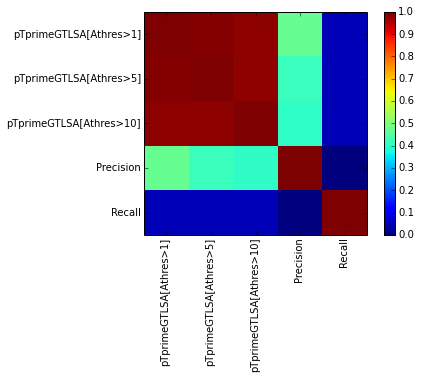

In [102]:
plt.imshow(correlation.as_matrix(),interpolation="None")
ticks=np.arange(0,shape(correlation)[0])
plt.xticks(ticks, keys, rotation='vertical')
plt.yticks(ticks, keys, rotation='horizontal')
plt.colorbar()
plt.clim(0,1)

---------------------------------------------
Regression x=['pTprimeGTLSA[Athres>1]'];y=['Precision']
Coefficients:  [[  1.30659872e-05]]
Mean squared error: 0.00
R^2: 0.16
---------------------------------------------
Regression x=['pTprimeGTLSA[Athres>5]'];y=['Precision']
Coefficients:  [[  2.33629658e-05]]
Mean squared error: 0.00
R^2: 0.19
---------------------------------------------
Regression x=['pTprimeGTLSA[Athres>10]'];y=['Precision']
Coefficients:  [[  1.68894082e-05]]
Mean squared error: 0.00
R^2: 0.21


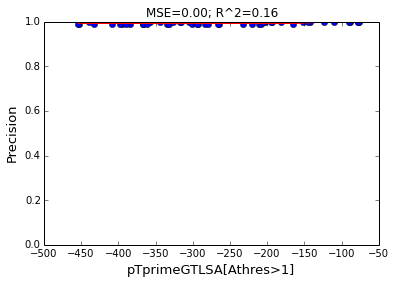

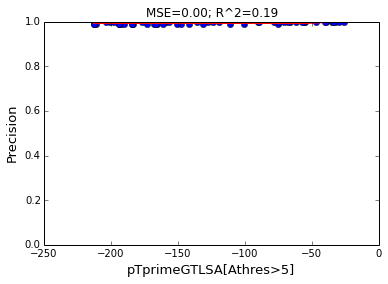

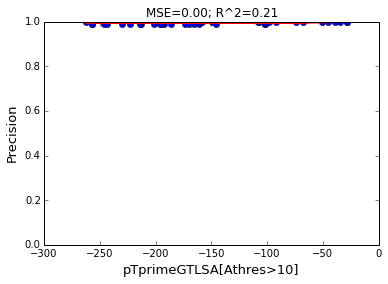

In [109]:
for threshold in [1,5,10]:
    x_attr = ["pTprimeGTLSA[Athres>{}]".format(threshold)]
    y_attr = ["Precision"]
    regression_results(df,x_attr,y_attr,PLOT=True)

In [111]:
def scatterplot(df,x_attr,y_attr,z_attr,z_data="",bucketize=True,cmap = plt.cm.rainbow):
    fig=plt.figure()

    
    plt.xlim(0,1.03)
    plt.ylim(0,1.03)
    plt.xlabel(x_attr,fontsize=14)
    plt.ylabel(y_attr,fontsize=14)
    plt.title(z_attr,fontsize=15)
    if bucketize:
        bounds = np.sort(list(set(bucketized_data)))
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        plt.scatter(df[x_attr],df[y_attr],c=z_data,edgecolors='none',alpha=0.7,cmap=cmap,norm=norm)        
        ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
        matplotlib.colorbar.ColorbarBase(ax2,cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds)#, format='%1i')
    else:
        plt.scatter(df[x_attr],df[y_attr],c=df[z_attr],edgecolors='none',alpha=0.7,cmap=cmap)
        plt.colorbar()
#         plt.clim(0,1)


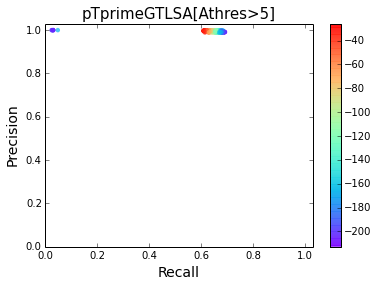

In [112]:
scatterplot(df,"Recall","Precision","pTprimeGTLSA[Athres>5]",bucketize=False)

# A more principled way of thresholding area based on cdf 

In [114]:
cd final_all_tiles/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM/final_all_tiles


In [115]:
objid=10 
indicatorMat = pkl.load(open("indMat{}.pkl".format(objid),'r'))
tile_area = np.array(indicatorMat[-1])

In [127]:
tile_area

array([ 0.09407412,  1.29193186,  3.43212569, ...,  0.64342846,
        0.03268251,  0.02040816])

In [129]:
np.histogram?

In [128]:
np.histogram(tile_area)

(array([6094,    0,    0,    0,    0,    0,    0,    0,    0,    1]),
 array([  1.23955752e-08,   1.33232206e+03,   2.66464412e+03,
          3.99696619e+03,   5.32928825e+03,   6.66161031e+03,
          7.99393237e+03,   9.32625443e+03,   1.06585765e+04,
          1.19908986e+04,   1.33232206e+04]))

In [136]:
len(tile_area)

6095

In [141]:
len(np.where(tile_area>2.5232351003151279)[0])

305

In [143]:
np.percentile(tile_area,95)

2.5232351003151279

In [144]:
pc80 = []
pc90 = []
pc95 = []
pc99 =[]
for objid in object_lst:
    indicatorMat = pkl.load(open("indMat{}.pkl".format(objid),'r'))
    tile_area = np.array(indicatorMat[-1])
    pc80.append(np.percentile(tile_area,80))
    pc90.append(np.percentile(tile_area,90))
    pc95.append(np.percentile(tile_area,95))
    pc99.append(np.percentile(tile_area,99))

In [146]:
print mean(pc80)
print mean(pc90)
print mean(pc95)
print mean(pc99)

0.950462415318
2.32587845371
4.88321840494
27.3905002108
